In [2]:
using LightGraphs, GraphPlot, Compose, PyPlot

INFO: Precompiling module LightGraphs.
INFO: Precompiling module GraphPlot.


In [3]:
m = 21;
x = linspace(-1,1,m); loc_x = repeat(x,inner = m);
y = linspace(-1,1,m); loc_y = repeat(y,outer = m);
Th = cos.(sqrt.(x.^2 .+ y'.^2) * pi/2);
Theta = 5 * ceil.(2.8 * Th - 0.2);
theta = Theta[:]; n = length(theta);
sigma = 1.0;
srand(1);
y = theta + sigma * randn(n); Y = reshape(y,21,21);

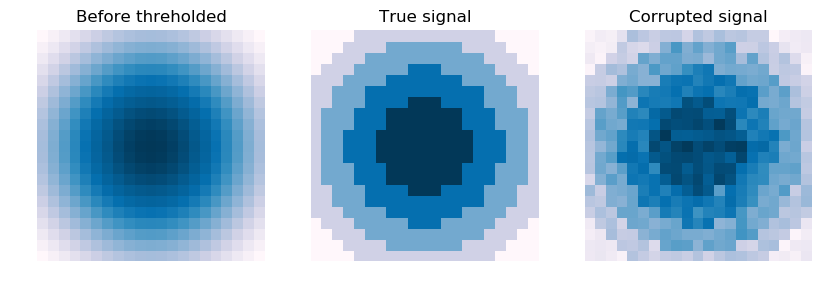

PyObject Text(0.5,1,'Corrupted signal')

In [4]:
fig, ax = subplots(1,3,figsize = (10, 3))
ax[1][:pcolormesh](Th, cmap = "PuBu");
ax[1][:set_title]("Before threholded")
ax[1][:axis]("off");
ax[2][:pcolormesh](Theta, cmap = "PuBu");
ax[2][:axis]("off");
ax[2][:set_title]("True signal")
ax[3][:pcolormesh](Y, cmap = "PuBu");
ax[3][:axis]("off");
ax[3][:set_title]("Corrupted signal")

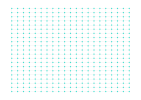

In [5]:
g = Grid([21;21]; periodic=false);
A = adjacency_matrix(g);
D = -full(incidence_matrix(g, oriented = true))';
gplot(g,loc_x,loc_y)

In [6]:
function BSGM_changepoint(y, D; v0 = 1e-1, v1 = 1e4, iter = 100)
    n = length(y);
    y = y - mean(y);
    theta = y + 0.0 * randn(n);
    delta = D * theta; m = length(delta);
    sigma = sum(y.^2)/length(y)
    q = zeros(n);
    for i = 1:iter
        q = 1./( 1 + sqrt(v0/v1) * exp.(delta.^2/2 * (1/v0 - 1/v1)/sigma) );
        tau = q/v0 + (1-q)/v1;
        theta = (speye(n) + D'*Diagonal(tau)*D) \ y;
        delta = D * theta;
        sigma = (sum((y-theta).^2) + sum((delta .* sqrt.(tau)).^2))/(n+m+1)
    end
    return theta, delta, q, sigma
end

BSGM_changepoint (generic function with 1 method)

In [7]:
function model_selection(out; v1 = 1e4)
    ind = find(out[3] .>= 0.5);
    D_res = D[ind,:]
    L_res = D_res'*D_res;
    A_res = (abs.(L_res) - L_res)/2;
    g_res = Graph(A_res);
    c = connected_components(g_res)
    t = zeros(n); i = 0;
    for ind in c
        i += 1;
        t[ind] = mean(y[ind]);
    end
    s = length(c)
    A_reduced = zeros(s,s)
    for i = 1:s
        for j = i+1:s
            A_reduced[i,j] = sum(A[c[i],c[j]])
        end
    end
    A_reduced = (A_reduced .> 0)
    A_reduced = A_reduced + A_reduced';
    L_reduced = Diagonal(sum(A_reduced,2)[:]) - A_reduced;
    e_vals = eig(L_reduced/v1)[1][2:end]
    first_term = -sum(log.(e_vals))/2;
    second_term = sum(log.(1+e_vals))/2;
    third_term = log(sum((y-t).^2)) * n/2;
    fourth_term = -1000
    return reshape(t,21,21), first_term + second_term + third_term + fourth_term 
end

model_selection (generic function with 1 method)

In [9]:
# Set v0_range
v0_range = 1e-3 * [1;5;10;15;20;25;100];

# Store final estimates and model selection scores
res = zeros(21,21,7)
model_score = zeros(7);

# Start loop
for i = 1:7
    v0 = v0_range[i];
    out = BSGM_changepoint(y,D, v0 = v0, iter = 50, v1 = 1e4);
    res[:,:,i], model_score[i] = model_selection(out);
end

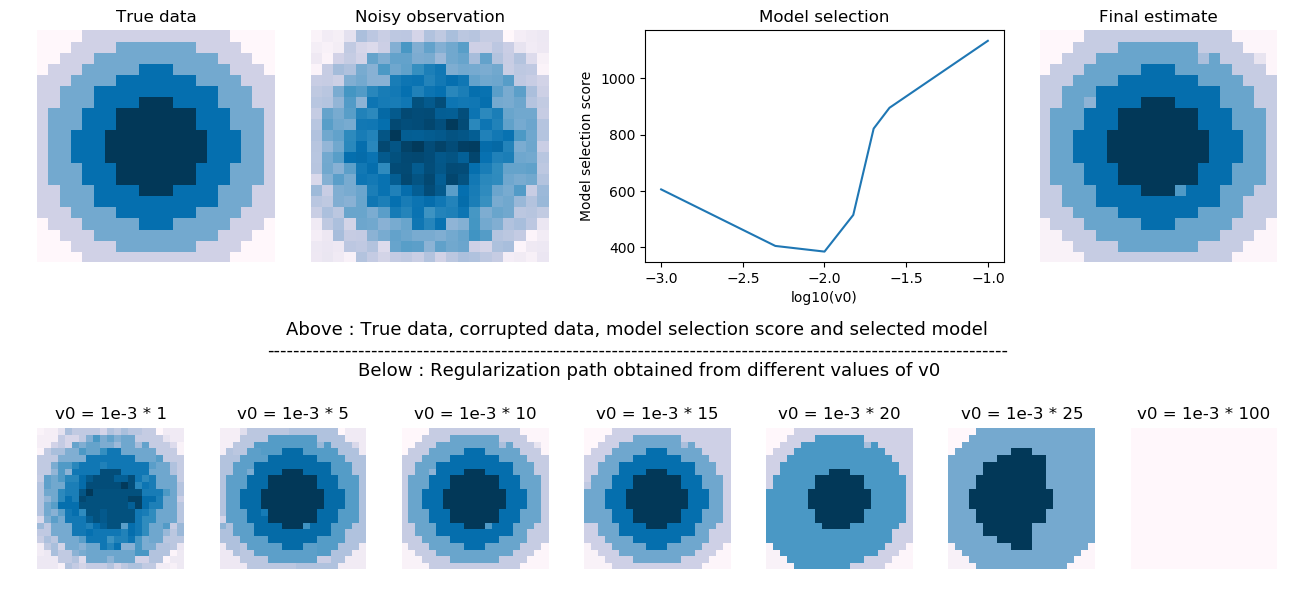

In [10]:
fig, axs = subplots(2,6,figsize = (16, 7))

suptitle("Above : True data, corrupted data, model selection score and selected model
------------------------------------------------------------------------------------------------------------------
    Below : Regularization path obtained from different values of v0",
    x = 0.5, y = 0.465, fontsize = 13)

axs[1] = subplot2grid((30,41), (0,0), rowspan = 13, colspan = 8)
axs[1][:pcolormesh](Theta,cmap = "PuBu")
axs[1][:set_title]("True data")
axis("off")

axs[2] = subplot2grid((30,41), (0,9), rowspan = 13, colspan = 8)
axs[2][:pcolormesh](Y,cmap = "PuBu")
axs[2][:set_title]("Noisy observation")
axis("off")

axs[10] = subplot2grid((30,41), (0,20), rowspan = 13, colspan = 12)
axs[10][:plot](log10.(v0_range[1:7]), model_score[1:7])
xlabel("log10(v0)");
ylabel("Model selection score")
axs[10][:set_title]("Model selection")

axs[11] = subplot2grid((30,41), (0,33), rowspan = 13, colspan = 8)
axs[11][:pcolormesh](res[:,:,findmin(model_score[1:7])[2]], cmap = "PuBu")
axs[11][:set_title]("Final estimate")
axis("off");

for i = 1:7
    axs[i+2] = subplot2grid((30,41), (22,i*6-6), rowspan = 8, colspan = 5)
    axs[i+2][:pcolormesh](res[:,:,i],cmap = "PuBu")
    v0 = Int(v0_range[i] * 10^3)
    axs[i+2][:set_title]("v0 = 1e-3 * $v0")
    axis("off")
end

savefig("F0.pdf")